In [66]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Module 4: Asset-Liability Management
---

A  number  of  profound  changes  have taken place in accounting standards and prudential regulations in most developed countries,  which  have  collectively  led to  the  emergence  of  a  new  investment paradigm  for  pension  funds.
Such changes have taken place at a time when  asset  allocation  practices  were firmly grounded around one overarching foundational concept, the 
policy portfolio,  which  had  dominated  pension fund  investment  practices  for  decades. 

Over  the  past  15  years  or  so,  this old  paradigm  has  progressively  been recognised  as  obsolete  for  at  least  two major, independent,  reasons.  The  first driving  force  behind  the  paradigm  shift has  been  the  progressive  recognition, accompanying  the  increased  focus  on liability  risk  management,  that  pension fund investments should not be framed in terms of one all-encompassing reference 
policy  portfolio,  but  instead  in  terms  of two  distinct  reference  portfolios.  These two portfolios are, respectively, a **liability-hedging portfolio (LHP)** (or in the case of individual investors we call it **goal-hedging porfolio (GHP)**), the sole purpose of which is to hedge away as effectively as  possible  the  impact  of  unexpected changes  in  risk  factors  affecting  liability values  (most  notably  interest  rate  and inflation  risks),  and  a  **performance-seeking  portfolio  (PSP)**,  for  which  the focus  is  to  provide  investors  with  an optimal risk-return trade-off, without any constraints  related  to  a  possible  liability mismatch. The second driving force has been the  recognition  that  there  is  no such  thing  as  a  meaningful  policy portfolio;  one  should  instead  think  in terms  of  a  meaningful  dynamic  policy portfolio strategy. 

These two driving  forces have  led  to  the  progressive  emergence of  a  modern  approach  to  **asset-liability management  (ALM)**  for  pension  funds. This  new  approach  has  been  labelled the  **"dynamic  liability-driven  investing" (DLDI)**  approach,  where  the liability-driven investing (LDI) element reflects the need to frame the pension fund portfolio strategy  in  terms  of  two  main  building blocks,  the  safe  LHP  and  the  risky  PSP, and where the dynamic element suggests that this split should evolve over time as a function of changes in market conditions.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font",family="serif")
plt.rc("font",size=15)

import functions as f

import ipywidgets as widgets
from IPython.display import display

# Present Value of Liabilities and Funding Ratio

When we manage assets against liabilities, what matters is not merely what happens on the asset side. What matters is what happens to the assets relative to the liabilities. What we are interested on is the **funding ratio (FR)**, which is the ratio of the current value of assets to the present value of the liabilities. 

$$FR = \frac{PV(assets)}{PV(liabilities)}$$

The present value of liabilities is the amount of the liability discounted on the relevant interest rate derived from the yield curve.
For simplicity, we'll assume that the yield curve is flat, and so the interest rate is the same for all horizons.

The present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is give by:

$$ PV(L) = \sum_{i=1}^{k} B(t_i) L_i$$

where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$

If we assume the yield curve is flat and the annual rate of interest is $r$ then $B(t)$ is given by

$$B(t) = \frac{1}{(1+r)^t}$$



In [68]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays $1 at time t where t is in years and r is the annual interest rate
    """
    return (1+r)**(-t)

In [69]:
discount(10, 0.03)

0.7440939148967249

In [70]:
def pv(l, r):
    """
    Compute the present value of a list of liabilities given by the time (as an index) and amounts
    """
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

Assume that you have 4 liabilities, of 1, 1.5, 2, and 2.5M dollars. Assume the first of these are 3 years away and the subsequent ones are spaced out 6 months apart, i.e. at time 3, 3.5, 4 and 4.5 years from now. Let's compute the present value of the liabilities based on an interest rate of 3% per year.

In [71]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])

pv(liabilities, 0.03)

6.233320315080045

We can now compute the funding ratio, based on current asset values:

In [72]:
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return assets/pv(liabilities, r)

Let's assume that your current asset value is 5M:

In [73]:
funding_ratio(5, liabilities, 0.03)

0.8021407126958777

A $FR <1$ means that at the current interest rates, your assets are not enough to cover your future liabilities. The opposite is the $FR > 1$.

Let's now see the impact of the asset value and interest rates on the $FR$.

In [74]:
def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    if fr>1:
        color = 'tab:green'
    elif fr<1:
        color = 'tab:red'
    else: color = 'tab:blue'
    plt.figure(figsize = (8,6))
    plt.bar('FR', fr, width = .2, color = color)
    plt.grid()
    plt.ylim(0,2)
    plt.legend([f'{fr*100:.2f}%'])

In [75]:
controls = widgets.interactive(show_funding_ratio,
                                   assets=widgets.IntSlider(min=1, max=10, step=1, value=5),
                                   r=(0, .20, .01))
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

### Liability hedging portfolios

As the illustration above shows, even if your assets do not go down in value, cash can be a risky asset if you think about the funding ratio rather than the asset value. Even though cash is a "safe asset" in the sense that the asset value does not go down, cash can be a very risky asset because the value of the liabilities goes up when interest rates go down. Therefore, if you think about your savings in terms of funding ratio (i.e. how much money do you have compared to what you need) then cash is a risky asset and can result in a decline in your funding ratio. That is when the concept of **Liability (Goal) Hedging Portfolio** arises.
We define them as portfolios that will generate cashflows that will match the date and nominal amount of those liability or goal payments. In other words, the liability or goal hedging portfolio is an asset portfolio that behaves exactly like the liabilities that we are trying to immunize against or that we are trying to protect. 

How do we do this? Generally, we invest in nominal bonds or sometimes inflation link bonds if the liabilities is a inflation linked, and we do
so in such a way so as to match the cashflows on the liability side and on the asset side.
Sometimes it turns out to be convenient to use fixed derivative income instruments. Either way, the objective is to find that combination of asset whose cashflows matches our liabilities.


# A stochastic model for interest rates: the CIR model

We're going to simulate changes in interest rates using the Cox-Ingersoll-Ross model, usually just called the CIR model:

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion, $b$ is the long term mean rate, $\sigma$ is the volatility parameter and $W_t$ is a Brownian motion.


This can be read as describing the change in interest at any point of time as a multiple of the distance of the current rate from it's long term mean plus a random value that depends on the volatility parameter.

Thus, we can start at some rate $r_0$ and generate a sequence of rates over time using the change in rate defined by the stochastic differential equation above. If we eliminate the ${\sqrt{r_{t}}}$ term we get the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 


### Short Rate vs Annualized Rate

The interest rate being described in the model is the "instantaneous" or "short rate". We will often want to think about interest rates as annualized rates, which means that the instantaneous rate needs to be compounded into an annual rate as follows:

$$ 1 + r_{annual} = e^{r_{inst}} $$
$$ r_{annual} = e^{r_{inst}}-1 $$


Equivalently:
$$ r_{inst} = ln(1 + r_{annual}) $$



### Implementation of the CIR Model

Let's start by defining a function to convert between instantaneous and annualized rates, and then write the code for generating the evolution of the interest rate:


In [76]:
def inst_to_ann(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.expm1(r)

def ann_to_inst(r):
    """
    Convert an instantaneous interest rate to an annual interest rate
    """
    return np.log1p(r)

In [77]:
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t) # just in case of roundoff errors going negative
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

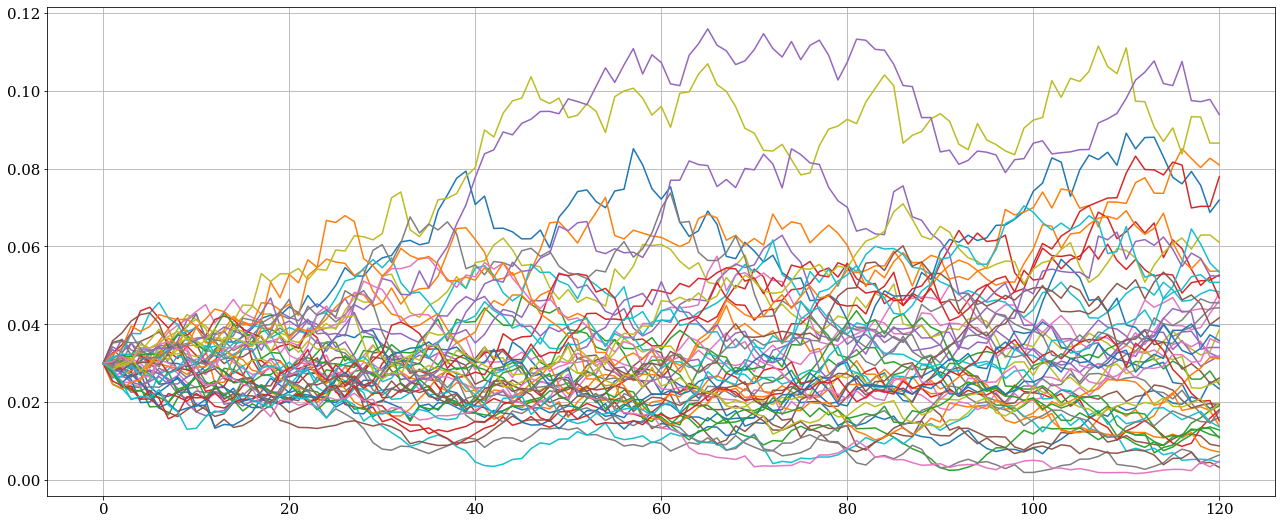

In [78]:
cir(n_scenarios=50).plot(legend=False, figsize=(22,9), grid=True)

In [79]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=20):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(22,9), grid = True, alpha = .8)

In [80]:
controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100, 2))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [81]:
import math
def cir(n_years = 10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    Generate random interest rate evolution over time using the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None: r_0 = b 
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 # because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0

    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ###
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well ...
        prices[step] = price(n_years-step*dt, rates[step])

    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

In [82]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=20):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(22,9), grid=True, alpha = .8)

In [83]:
controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

Assume our liabilities are to pay one dollar in 10 years time. Clearly, the liability is perfectly matched by the price of a zero coupon bond that matures in 10 years. Therefore, this is perfectly matched by buying a zero coupon bond. 

In [92]:
# My starting asset value today: cash in hand
a_0 = 0.75

# Simulate the next 10 years
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=20)

# Liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices

# Today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = pv(pd.Series(data=[1], index=[10]), 0.03)

# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0

# And my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices

# How about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

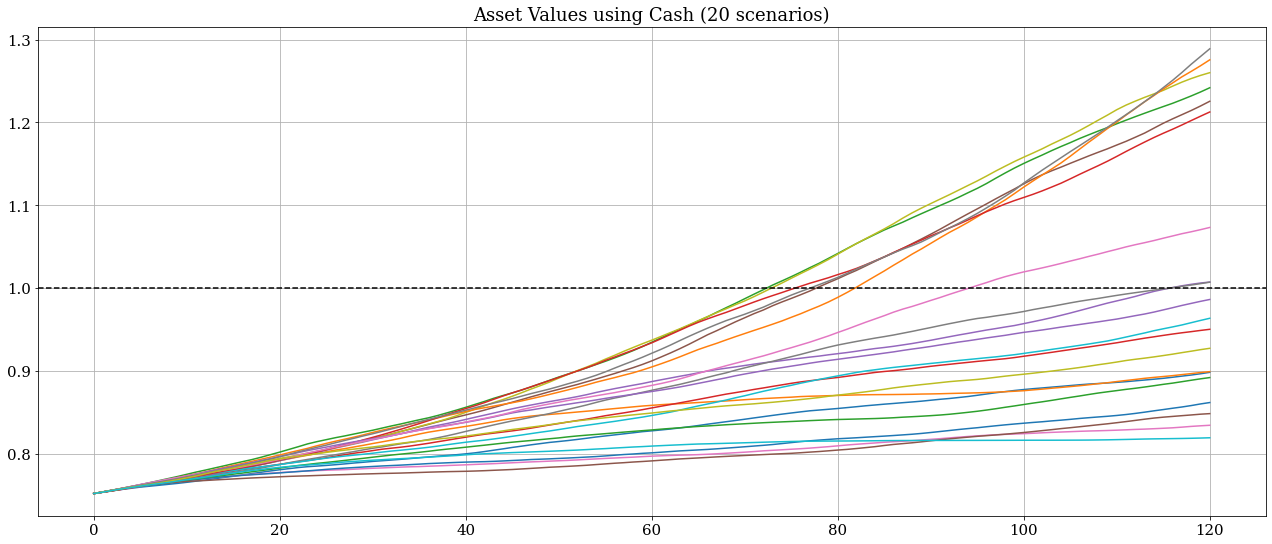

In [93]:
av_cash.plot(title='Asset Values using Cash (20 scenarios)', legend=False, figsize=(22,9), grid = True)
plt.axhline(1, color = 'k', linestyle = 'dashed')

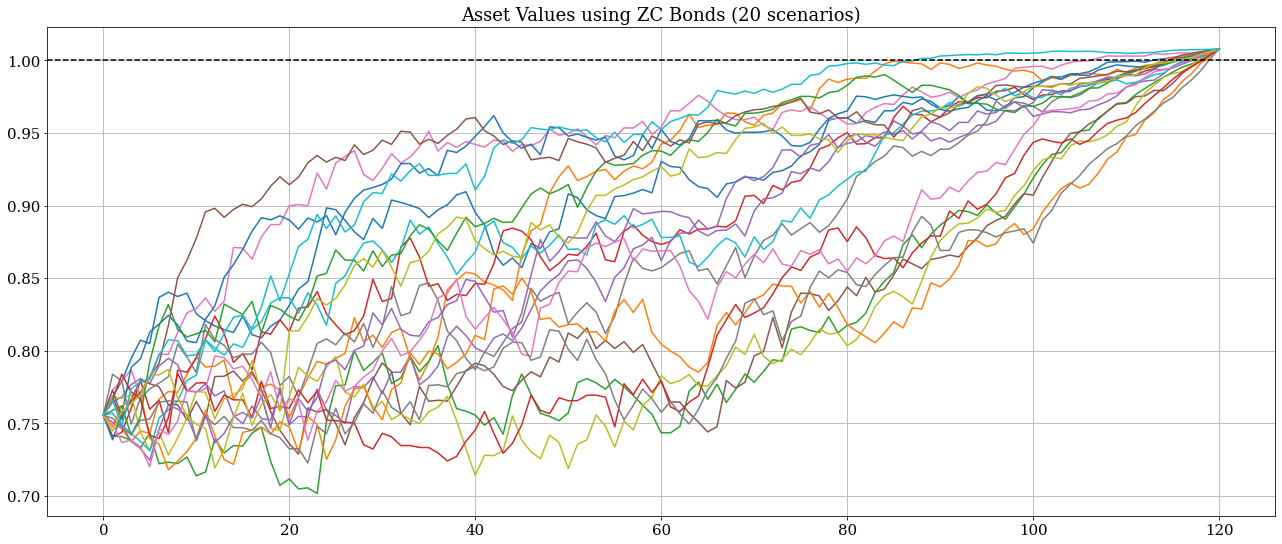

In [94]:
av_zc_bonds.plot(title='Asset Values using ZC Bonds (20 scenarios)', legend=False, figsize=(22,9), grid = True)
plt.axhline(1, color = 'k', linestyle = 'dashed')

Investing in cash can lead to a much higher terminal value of the assets than the one needed to cover the liabilities, but can also lead to a lower one. By investing in a perfectly duration matched zero cupon bond, we always end up above the liability level.

Let's now compare the changes in the Asset Values using Cash or ZC Bonds.

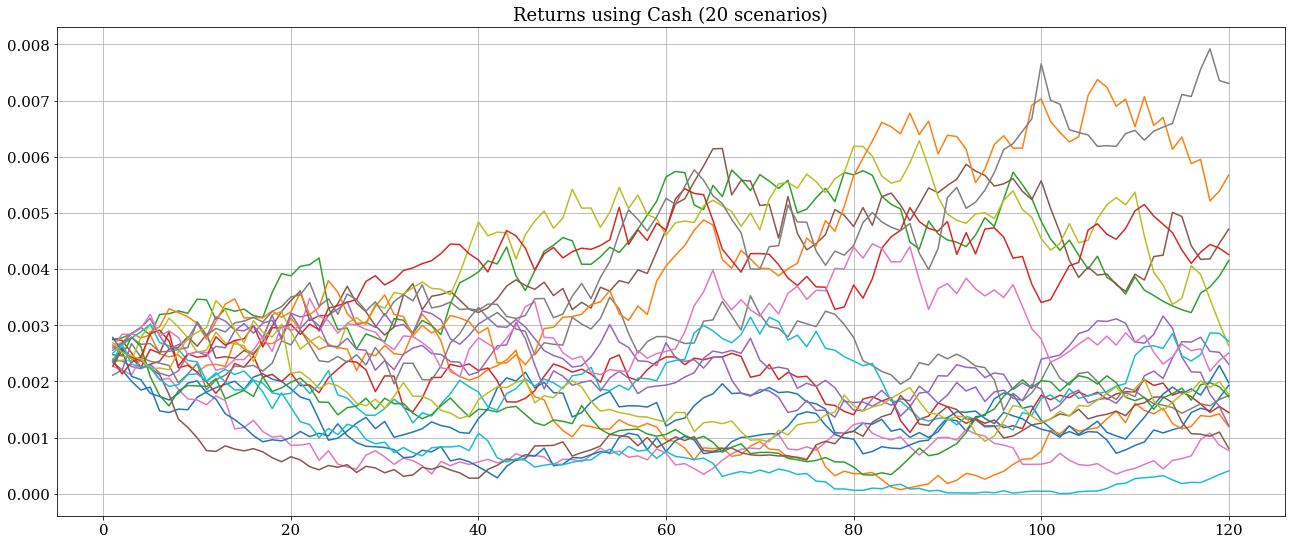

In [95]:
av_cash.pct_change().plot(title='Returns using Cash (20 scenarios)', legend=False, figsize=(22,9), grid = True)

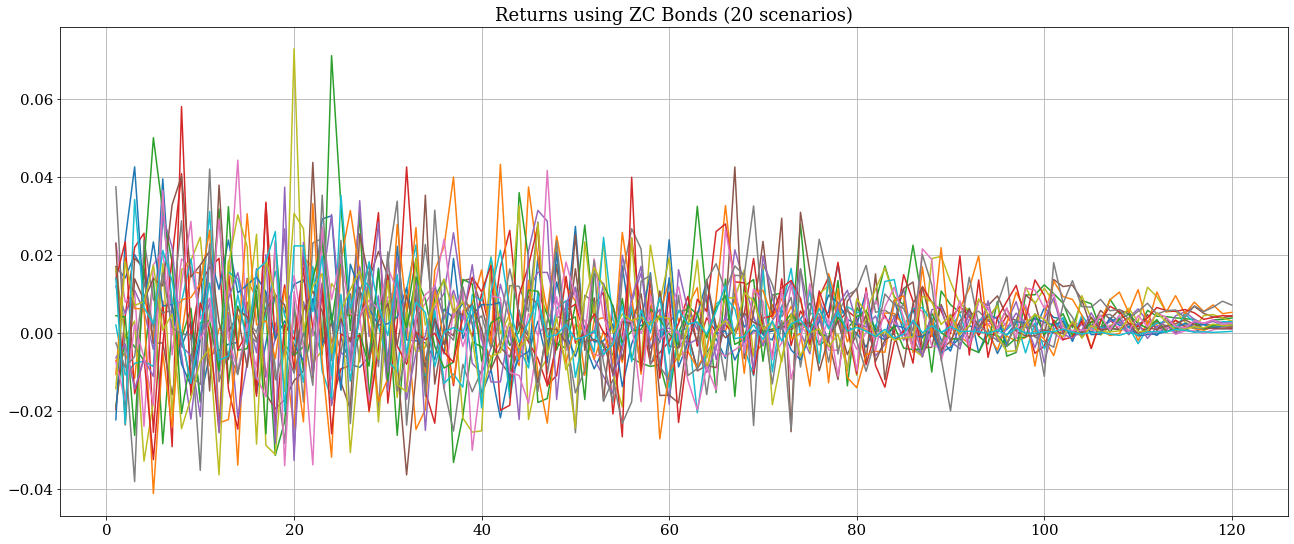

In [96]:
av_zc_bonds.pct_change().plot(title='Returns using ZC Bonds (20 scenarios)', legend=False, figsize=(22,9), grid = True)

Let's now look at what really matter, which is the changes in the Funding Ratio on the two alternatives.

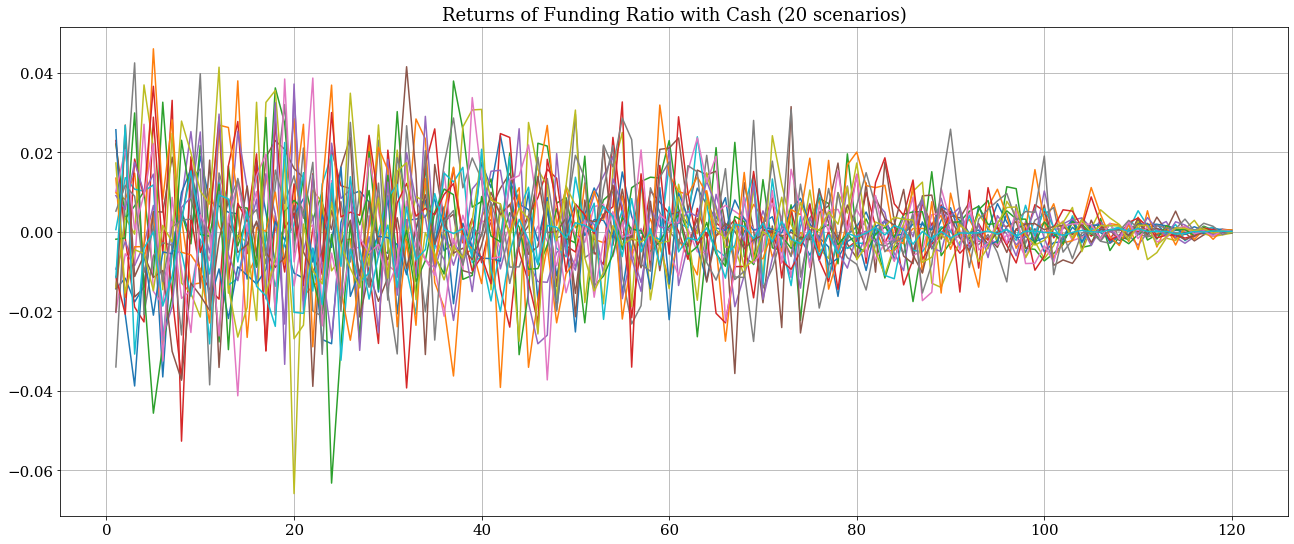

In [97]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (20 scenarios)', legend=False, figsize=(22,9), grid = True)

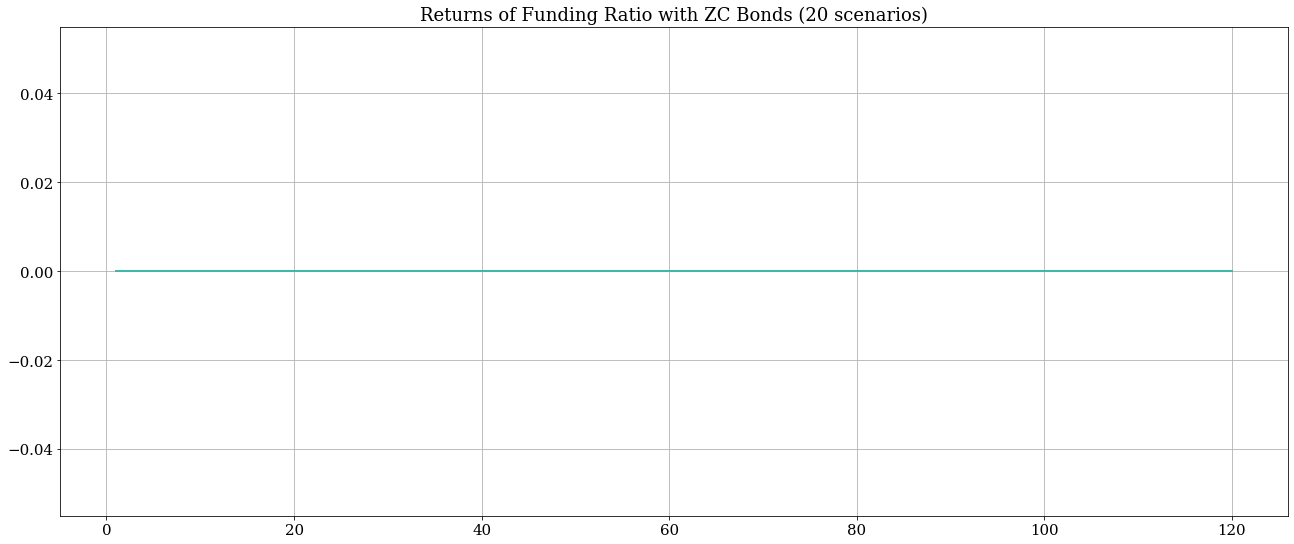

In [98]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZC Bonds (20 scenarios)', legend=False, figsize=(22,9), grid = True)

If the Funding Ratio does not change, it means that we were able to perfectly hedge our liabilities. The message here is: the safe asset is not something that can be defined in an absolute term, not something that can be defined in isolation from the investor.
The safe asset is the asset that is safe with respect to the investor and more precisely with respect to the specific goal of the investor.


### Terminal Funding Ratios

We can look at this in terms of Terminal Funding Ratios. Let's repeat this with a large number of simulations:

In [99]:
# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = cir(r_0=0.03, b=0.03, n_scenarios=10000)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = a_0/zc_0
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest over time
av_cash = a_0*(rates/12+1).cumprod()

# Terminal FR
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]


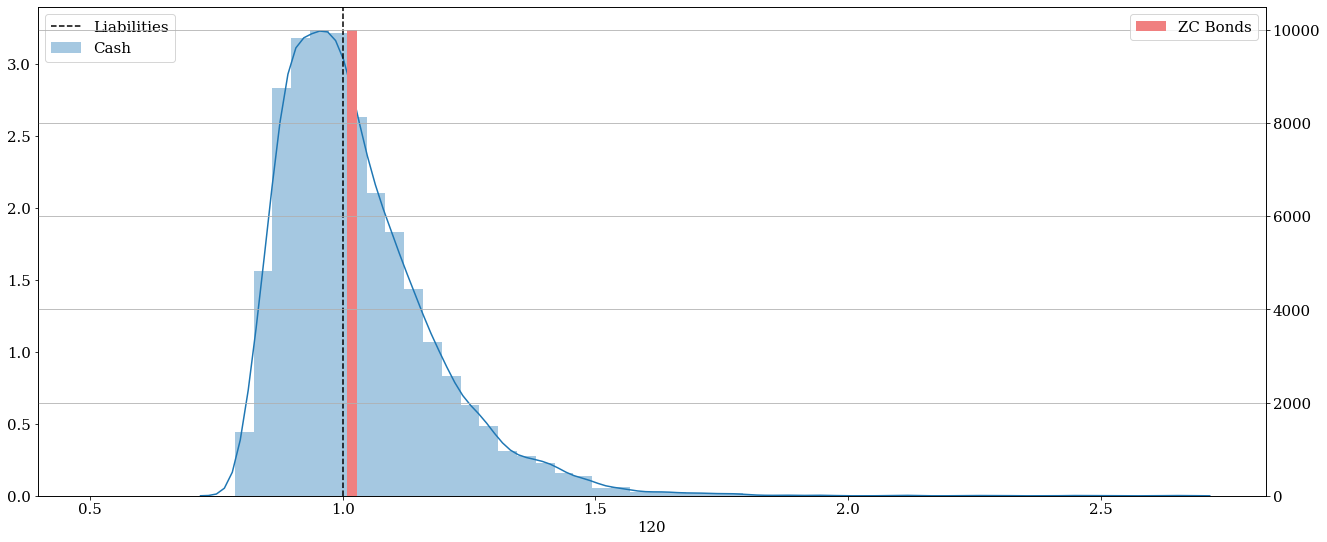

In [100]:
fig,ax = plt.subplots(figsize = (22,9))
sns.distplot(tfr_cash, label = 'Cash')
plt.axvline(1, color = 'k', linestyle = 'dashed', label = 'Liabilities')
plt.legend(loc = 'upper left')

ax1 = ax.twinx()
ax1.hist(tfr_zc_bonds, label = 'ZC Bonds', bins = 50, color = 'lightcoral')
plt.legend()
plt.grid()

### Conclusion

As you can see, hedging a future liability with cash or even cash-like instruments can be very risky. Although Zero Coupon Bonds are nominally risky and can see a great deal of price fluctuation, they vary in price in tandem with the liabilities, resulting in a much better hedge.

Of course, this makes two convenient assumptions that are often not true in practice. First, it assumes that zero coupon bonds with the perfect maturities are always available, and second, it assumes that you have the intial assets to be able to afford the hedge.

- We will address the first by holding a portfolio of non zero coupon bonds that will behave like a zero coupon bond in the sense that it can be liquidated at a particular maturity for an amount that is immunized against changes in interest rates. 

- We will address the second issue by introducing a second building block to deliver the higher performance to try and close the gap between your current assets and the upside target.


# Liabilities Hedging Portfolio Construction with Duration Matching

A ZC bond matching the duration of our liabilities is a very good hedge, but the problem is that it's not always easy to find these zero-coupon bonds that are perfectly matched to your liabilities.  Nevertheless, we can do something somewhat similar by just holding a portfolio of
regular coupon-bearing bonds or coupon-paying bonds as long as we can do this duration matching. 

Let's first set some basic bond concepts such as:

- Price
- Yield
- Duration

In [101]:
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):
    """
    Returns the series of cash flows generated by a bond,
    indexed by the payment/coupon number
    """
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal # add the principal to the last payment
    return cash_flows

def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)

In [102]:
bond_price(20, 100, .05, 2, .055)

93.98047473498784

## Bond prices change with interest rates

Consider the following chart that shows the change in value of a bond for interest rates from 2% to 10%. The bond in question is a 10 year bond that pays a 5% coupon semiannually and the face value is $100.

In [103]:
rates = np.linspace(.01, .10, num=20)
prices = [bond_price(10, 100, 0.05, 2, rate) for rate in rates]

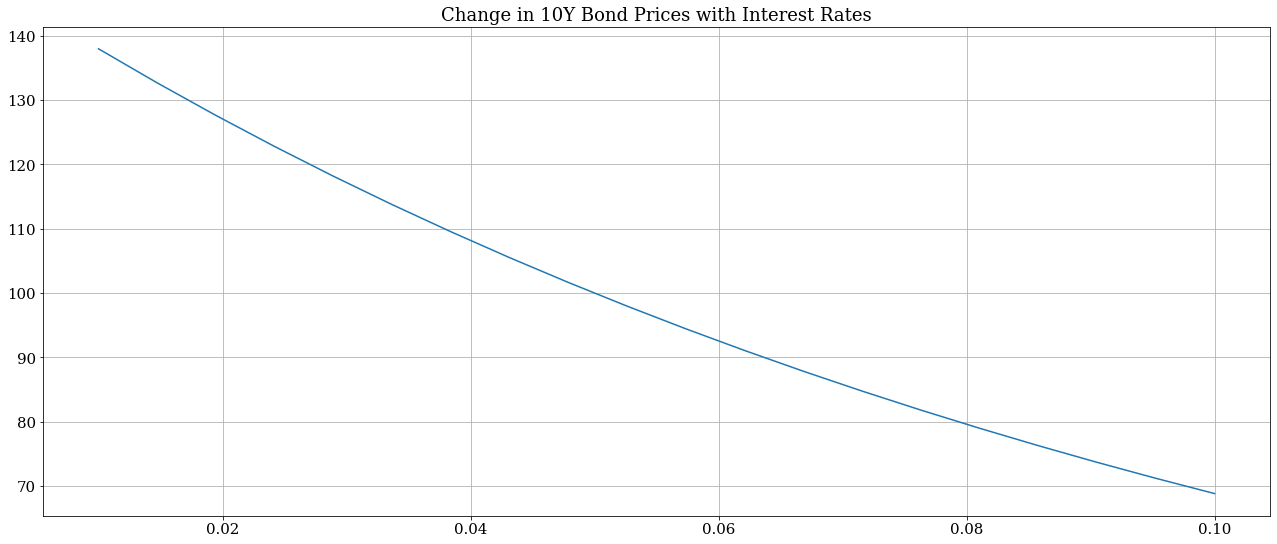

In [104]:
pd.DataFrame(data=prices, index=rates).plot(title="Change in 10Y Bond Prices with Interest Rates", legend=False, figsize = (22,9), grid=True)

Assume that we have a liability of $100 in 10 years. Clearly, we cannot use this as a hedge, since we would be severely underfunded if interest rates rise, and over funded if they fall. If we had a Zero Coupon bond, we could purchase that, but Zero Coupon bonds of specific maturities arent always available.

What is available are various bonds with maturities from 5 to 30 years. How do we build a portfolio that has the same sensitivity to interest rates as our liabilities do? If they both respond the same way to changes in interest rates, we can effectively obtain immunity to interest rate changes.

One way to do this is through **Duration Matching**. The duration of a bond measures its senstivity to interest rate changes. Therefore, we match the duration of the liabilities to the duration of the bond portfolio. As it happens, the duration of a bond which is computed as the weighted average time of the cash flows, weighted by the cash flows. Thus the duration of a Zero Coupon bond is just the maturity, since there is a single cash flow at maturity.

The **Macaulay Duration** is the weighted average number of periods you have to be invested in the bond to get the present value of the bond back. The **Modified Duration**, on the other hand, is a more direct measure of the change of the bond price product of changes in interest rates (the  first derivative of the bond price with respect to interest rates). It is computed by dividing the Macaulay Duration into a plus the interest rate.

In [105]:
def macaulay_duration(flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows, given a per-period discount rate
    """
    discounted_flows = discount(flows.index, discount_rate)*flows
    weights = discounted_flows/discounted_flows.sum()
    return np.average(flows.index, weights=weights)

def modified_duration(flows, discount_rate):
    """
    Computes the Modified Duration of a sequence of cash flows, given a per-period discount rate
    """
    return macaulay_duration(flows, discount_rate)/(1 + discount_rate)

In [106]:
macaulay_duration(bond_cash_flows(3, 1000, .06, 2), 0.06/2)

5.579707187194534

In [107]:
modified_duration(bond_cash_flows(3, 1000, .06, 2), 0.06/2)

5.417191443878187

# Duration Matching

Duration matching can either be done with the Macaulay Duration or the Modified Duration.

Assume we have a liability of \\$100 K in 10 years time and another of \\$100K in 12 years time. Assume interest rates are 4%. What is the duration of the liabilities?

In [108]:
liabilities = pd.Series(data = [100000, 100000], index=[10, 12])
print(modified_duration(liabilities, .04).round(2))

10.54


If we could, we would buy a ZC bond of 10.54 years of durations. Let's rather assume we have two types of bonds available. We have a 10 year bond and a 15 year bond. Each of them pays a 5% coupon once a year and has a face value of \\$1000. What are the durations of these bonds?

In [109]:
md_10 = modified_duration(bond_cash_flows(10, 1000, .05, 1), .04)
md_10

7.875864253926185

In [110]:
md_20 = modified_duration(bond_cash_flows(20, 1000, .05, 1), .04)
md_20

13.023767425140308

Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 7.87 + (1-w_s) \times 13.02 = 10.54$$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$


**Disclaimer:** This duration matching is only protecting us from level movements of the yield curve. The curve can also steepen or flatten, as well as change its curvature. Anyways, we will keep it simple an protect from parallel movements.

In [111]:
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective
    duration that matches cf_t
    """
    d_t = modified_duration(cf_t, discount_rate)
    d_s = modified_duration(cf_s, discount_rate)
    d_l = modified_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)

While we are at it, let's update the funding ratio we developed the last time to support cash flows in the assets:

In [112]:
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return pv(assets, r)/pv(liabilities, r)

In [113]:
short_bond = bond_cash_flows(10, 1000, .05, 1)
long_bond = bond_cash_flows(20, 1000, .05, 1)
w_s = match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478963

In [114]:
# Prices
p_short = bond_price(10, 1000, .05, 1, 0.04)
p_long = bond_price(20, 1000, .05, 1, 0.04)

#Initial assets
a_0 = 130000

What are the cashflows that this portfolio is going to generate?
Each bond is going to generate:

$$\frac{a_0\omega_i}{Price_i}* CF$$

In [115]:
cf_assets=pd.concat([a_0*w_s*short_bond/p_short,a_0*(1-w_s)*long_bond/p_long])
modified_duration(cf_assets, 0.04)

10.539230177969609

In [116]:
modified_duration(liabilities, 0.04)

10.539230177969609

In [117]:
# Current fr
cfr = funding_ratio(cf_assets, liabilities, 0.04)
cfr

0.9998760012192479

We now want to compare the changes in the funding ratio with respect to changes in the interest rates of different portfolios:
- The duration matched portfolio
- A portfolio formed only by the short bond
- A portfolio formed only by the long bond

In [118]:
lb_assets = a_0*long_bond/p_long
funding_ratio(lb_assets, liabilities, 0.04)

0.9998760012192477

In [119]:
sb_assets = a_0*short_bond/p_short
funding_ratio(sb_assets, liabilities, 0.04)

0.9998760012192477

In [120]:
rates = np.linspace(0, .1, 20)
fr_change = pd.DataFrame({
    "Long Bond":[funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond":[funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds":[funding_ratio(cf_assets, liabilities, r) for r in rates]
}, index=rates)

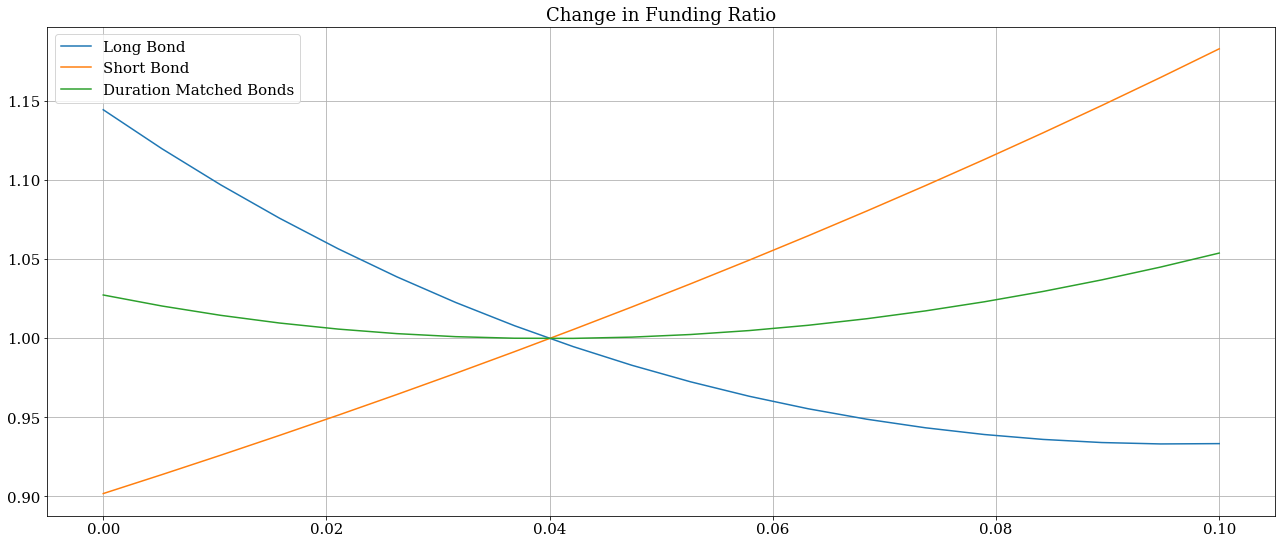

In [121]:
fr_change.plot(title='Change in Funding Ratio', figsize=(22,9), grid = True)

The funding ratio of the duration matched portfolio changes very little with changes in interest rates. You can secure future liabilities by matching the duration of your liabilities with the durations of your assets to immunize yourself against level shifts in the yield curve. In practice, you might also want to protect against changes in the slope and curvature of the yield curve by using convexity hedging, but duration hedging is a simple but essential step towards ensuring that you will have the money to meet your liabilities when interest rates fluctuate.


# Liability Driven Investing: choosing the right policy portfolio

We have seen that if we are fully funded, the best way to ensure that we will remain fully funded and be able to meet our liabilities is to build a portfolio of immunized bonds that are designed to match the future liability cash flows.
In practice, few of us, both in a Pension Fund context and even more so in a Personal Investment context, already have the assets to fund all future liabilities. Other than in cases where 100% funding ratios are mandated by law, the far more common situation is that we typically do not have the assets we need to fully fund our future liabilities.

LDI strategies involve a simple split between two building blocks: a Performance Seeking Portfolio (PSP) and a Liability Hedging Portfolio (LHP). The PSP is where we consciously take some risk in the hope that the extra risk is well rewarded - in other words, a high Sharpe Ratio portfolio. The LHP is the immnized bond portfolio that designed to protect us in case the worst case happens and we do not get the returns that we hope for from the PSP. 

This raises the question of how much to allocate to the PSP and how much to the LHP. Clearly, allocating more to the PSP entails a higher expected return but a higher degree of risk. On the other hand, allocating too little to the PSP means less risk, but lower expected return. Thus, the decision of how much to allocate to the PSP vs the GHP is essentially a risk budgeting exercise.

First, we will need to make a choice of the PSP. For now, we will start with the Geometric Brownian Motion based random stock portfolios.

We will also need to pick a GHP. We can use Zero Coupon Bonds driven by random changes in interest rates using the CIR model. Since these are Zero Coupon, they are already immunized against interest rates if they are held to maturity. In practice, even if we are not able to buy Zero Coupon bonds, we can construct bond portfolios that are designed to be insensitive to interest rates through duration matching.

In this section, we will develop the code necessary to simulate bond prices of coupon-bearing bonds and see how their prices change as interest rates fluctuate. We will limit ourselves to Treasury Bonds and ignore credit risk (i.e. the risk of default on the Bond).


## LHP

We are going to start by generating bond prices of a coupong bearing bond, which will be the main component of our LHP.
Let's assume that we are holding a bond that has a maturity of 5 years and pays a 5% coupon and the coupon is paid out each month and interest rates change from 3% to 3.2%

In [122]:
bond_price(5,100,.05,12,.03)

109.27539294780118

In [123]:
bond_price(5,100,.05,12,.032)

108.30670320101602

In order to use our generated interest rates to find the resulting bond prices, we need to modify the ``bond_price`` function to support vectors. ``bonds_price`` useses ``pv`` and ``pv`` uses ``discount``. 

```python
def discount(t, r):
    return (1+r)**(-t) ```
    
Needs to be replace by:

In [124]:
def discount(t, r):
    """
    Compute the price of a pure discount bond that pays a dollar at time period t
    and r is the per-period interest rate
    returns a |t| x |r| Series or DataFrame
    r can be a float, Series or DataFrame
    returns a DataFrame indexed by t
    """
    discounts = pd.DataFrame([(r+1)**-i for i in t])
    discounts.index = t
    return discounts

And

```python
def pv(flows, r):
    dates = flows.index
    discounts = discount(dates, r)
    return (discounts*flows).sum() ```
    
Needs to be replace by:

In [125]:
def pv(flows, r):
    """
    Compute the present value of a sequence of cash flows given by the time (as an index) and amounts
    r can be a scalar, or a Series or DataFrame with the number of rows matching the num of rows in flows
    """
    dates = flows.index
    discounts = discount(dates, r)
    return discounts.multiply(flows, axis='rows').sum()

In [126]:
rates, zc_prices = cir(10, 200, b=0.03, r_0 = 0.03)

In [127]:
rates[[1,2,3]].head()

1         2         3
0  0.030000  0.030000  0.030000
1  0.033040  0.032076  0.023581
2  0.033510  0.029878  0.023812
3  0.031388  0.026096  0.020953
4  0.030096  0.025312  0.022231

At t=0 interest rates are the same for all scenarios, so the price will also be the same.

In [128]:
bond_price(5,100,.05,12, rates.iloc[0][[1,2,3]])

1    109.275393
2    109.275393
3    109.275393
dtype: float64

At t=1, interest rates change, and therefore bond prices start to diverge. It is important to notice that there is another factor affecting the price, which is duration.

In [129]:
bond_price(5-1/12,100,.05,12, rates.iloc[1][[1,2,3]])

1    107.686920
2    108.142977
3    112.253174
dtype: float64

Let's now modify the ``bond_price`` function in order to account for this two changes in case we provide a DataFrame of interest rates as a parameter.

In [130]:
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    If discount_rate is a DataFrame, then this is assumed to be the rate on each coupon date
    and the bond value is computed over time.
    i.e. The index of the discount_rate DataFrame is assumed to be the coupon number
    """
    if isinstance(discount_rate, pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.loc[t] = bond_price(maturity-t/coupons_per_year, principal, coupon_rate, coupons_per_year,
                                      discount_rate.loc[t])
        return prices
    else: # base case ... single time period
        if maturity <= 0: return principal+principal*coupon_rate/coupons_per_year
        cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
        return pv(cash_flows, discount_rate/coupons_per_year)

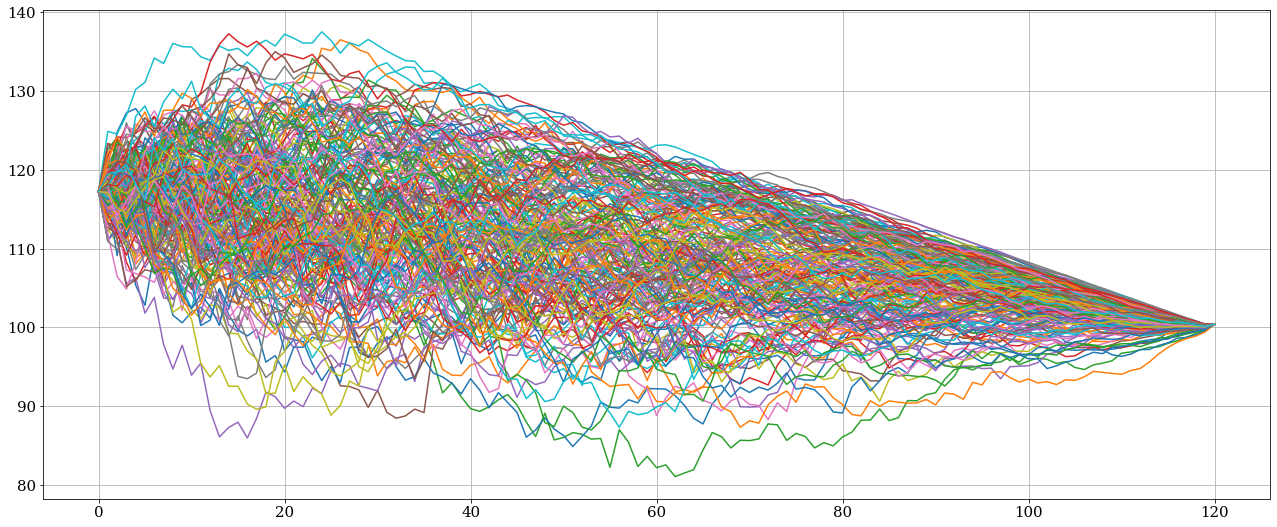

In [131]:
bond_price(10, 100, .05, 12, rates).plot(legend=False, figsize=(22,9), grid = True)

Now let's compute the return generated by these bonds. Remember that the return on a bond is not only the change in its price, but also the coupons received. If we only computed the price return, we would get:

In [132]:
prices = bond_price(10, 100, .05, 12, rates)
rets = prices.pct_change().dropna()

In [133]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

In [134]:
annualize_rets(rets, 12)

0     -0.015387
1     -0.015387
2     -0.015387
3     -0.015387
4     -0.015387
         ...   
195   -0.015387
196   -0.015387
197   -0.015387
198   -0.015387
199   -0.015387
Length: 200, dtype: float64

In order to compute the total return, we need to include the coupons.

In [135]:
def bond_total_return(monthly_prices, principal, coupon_rate, coupons_per_year):
    """
    Computes the total return of a Bond based on monthly bond prices and coupon payments
    Assumes that dividends (coupons) are paid out at the end of the period (e.g. end of 3 months for quarterly div)
    and that dividends are reinvested in the bond
    """
    coupons = pd.DataFrame(data = 0, index=monthly_prices.index, columns=monthly_prices.columns)
    t_max = monthly_prices.index.max()
    pay_date = np.linspace(12/coupons_per_year, t_max, int(coupons_per_year*t_max/12), dtype=int)
    coupons.iloc[pay_date] = principal*coupon_rate/coupons_per_year
    total_returns = (monthly_prices + coupons)/monthly_prices.shift()-1
    return total_returns.dropna()

In [136]:
p = bond_price(10, 100, .05, 12, rates[[1,2,3,4]])
tot_rets = bond_total_return(p, 100, .05, 12)
annualize_rets(tot_rets, 12)

1    0.031657
2    0.029587
3    0.027479
4    0.034024
dtype: float64

The total return is therefore about 3%. Why are not all of them equal? Because we are assuming that the coupons are reinvested in bonds at changing interest rates.

## Putting it all together: Monte Carlo Simulation of Asset Allocation

Now that we have a way to generate prices from which to derive returns, we can experiment with allocating across the different Asset Classes.

Let's start by examining the performance of a 70-30 allocation to Stocks and Bonds. Assume Stocks return an average of 7% per year with a 15% vol and use the CIR model to generate bond prices for a 10 year and 30 year bond that pays a 5% coupon. For simplicity, assume the coupon is paid monthly to avoid having to deal with partial coupons. Assume the Bond Portfolio consists of 60% in the 10 year bond and 40% in the 30 year bond.


In [137]:
price_10 = bond_price(10, 100, .05, 12, rates)
price_10[[1,2,3]].tail()

1        2        3
116  100.973    101.1   101.11
117  100.757  100.831  100.836
118  100.504  100.559  100.566
119  100.266  100.261  100.276
120  100.417  100.417  100.417

In [138]:
price_30 = bond_price(30, 100, .05, 12, rates)
price_30[[1,2,3]].tail()

1        2        3
116  148.647  156.972  157.664
117  150.722  157.222  157.691
118  150.404  157.648  158.636
119  153.903  152.496   156.55
120  155.095  155.765  157.859

In [139]:
rets_30 = bond_total_return(price_30, 100, .05, 12)
rets_10 = bond_total_return(price_10, 100, .05, 12)

Now we can assume monthly rebalancing and compute the monthly returns of the bond portfolio:

In [140]:
rets_bonds = .6*rets_10 + .4*rets_30

#Mean across scenarios at each point in time
mean_rets_bonds = rets_bonds.mean(axis='columns')
f.summary_stats(pd.DataFrame(mean_rets_bonds))

Annualized Return  Annualized Vol  Skewness  Kurtosis  \
0           0.036052        0.005465  0.267193  3.296253   

   Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  Max Drawdown  
0                -0.000504            0.000201       1.07783     -0.001594

Let's now generate the equity prices.

In [141]:
price_eq = f.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
price_eq.shape

(121, 500)

In [142]:
rets_eq = price_eq.pct_change().dropna()
f.summary_stats(pd.DataFrame(rets_eq.mean(axis = 1)))

Annualized Return  Annualized Vol  Skewness  Kurtosis  \
0           0.072297        0.006979  0.218714  2.614529   

   Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  Max Drawdown  
0                -0.002647           -0.002206      5.899135           0.0

Let's now combine the bond portfolio with the equity portfolio.

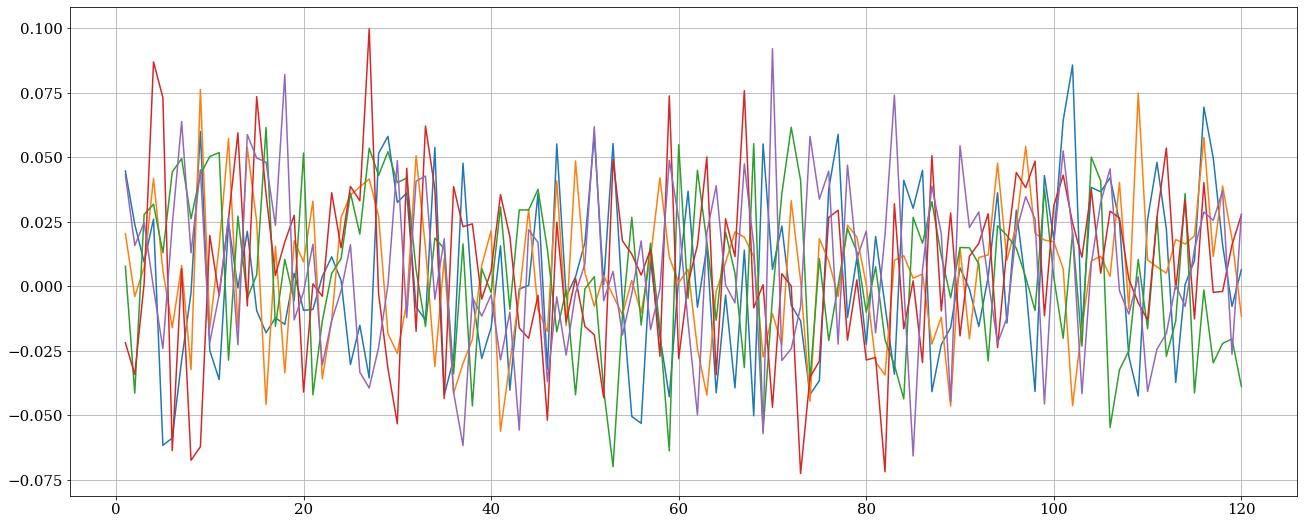

In [143]:
rets = .70*rets_eq + 0.3*rets_bonds
rets[[1,2,3,4,5]].plot(legend=False, figsize = (22,9), grid= True)

In [144]:
rets_mean = rets.mean(axis='columns')
f.summary_stats(pd.DataFrame(rets_mean))

Annualized Return  Annualized Vol  Skewness  Kurtosis  \
0           0.062351        0.008056  0.000006  3.363021   

   Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  Max Drawdown  
0                -0.001264           -0.000168      3.908729     -0.001606

# Optimal Policy: how to allocate between the PSP and LHP?

We are going to start with an heuristic strategies that allocate a ﬁxed percentage of the investor’s assets to the PSP and the LHP. We will then point that while the LDI principle advocates separation between performance and hedging, investor’s welfare not only depends on the PSP performance and the hedging qualities of the LHP, but also on the hedging properties of the PSP and the LHP performance. This interaction result suggests in particular that an investor may beneﬁt from improving liability-hedging characteristics of their performance-seeking portfolios. We ﬁnally move on to the analysis of optimal LDI strategies that maximize investor’s welfare according to a liability-driven objective.


## Naive Risk Budgeting Strategies between PSP and GHP
We have already naively formed a portfolio of 70 PSP - 30 LHP, but we are now going to do it in a more systematic and methodical way.


In [145]:
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

## The Simplest Allocator - Fixed Mix

The allocator's job is to come up with a time series of weights, so let's create the simplest possible allocator - one that puts a fixed fraction in the first portfolio and the remaining in the second one.

In [146]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)

We are now ready to rerun the experiment we ran last time: a bond portfolio of 60% in the 10 year bond and 40% in the 30 year bond to generate a fixed mix bond portfolio.

In [147]:
rates, zc_prices = cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = bond_price(10, 100, .05, 12, rates)
price_30 = bond_price(30, 100, .05, 12, rates)
rets_30 = bond_total_return(price_30, 100, .05, 12)
rets_10 = bond_total_return(price_10, 100, .05, 12)
rets_bonds = bt_mix(rets_10, rets_30, allocator=fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
f.summary_stats(pd.DataFrame(mean_rets_bonds))

Annualized Return  Annualized Vol  Skewness  Kurtosis  \
0            0.03545        0.003678  0.275362  3.071798   

   Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  Max Drawdown  
0                -0.001254           -0.000861      1.441988           0.0

Next, we'll use this to create a 70-30 Stock Bond Mix. First, we'll generate stock returns:

In [148]:
price_eq = f.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()

And next, we'll use the mix backtester to build a 70-30 Stock-Bond mix. One way to assess the performance is, as before, to generate a composite and produce summary stats on the composite. We'll also examine a second approach, which is to compute summary stats on each scenario and average the summary stats.

In [149]:
rets_7030b = bt_mix(rets_eq, rets_bonds, allocator=fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis='columns')
f.summary_stats(pd.DataFrame(rets_7030b_mean))

Annualized Return  Annualized Vol  Skewness  Kurtosis  \
0           0.061088        0.004498  0.138731  2.602318   

   Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  Max Drawdown  
0                -0.002868           -0.002503      6.726845           0.0

In [150]:
# Approach 2: compute stats on each scenario and then average
summaries = f.summary_stats(rets_7030b)
summaries.mean()

Annualized Return          0.055589
Annualized Vol             0.107333
Skewness                   0.023360
Kurtosis                   2.974386
Cornish-Fisher VaR (5%)    0.045585
Historic CVaR (5%)         0.057609
Sharpe Ratio               0.233470
Max Drawdown              -0.205741
dtype: float64

## Distribution of Terminal Values and Measuring Risk Budget Efficiency

We have computed the statistics for mean returns across very different scenarios. What has a much more meaningful interpretation, though,are the statistics of all the possible final outcomes. That is, we should not focus on mean returns, but rather on cummulative returns at the final date.

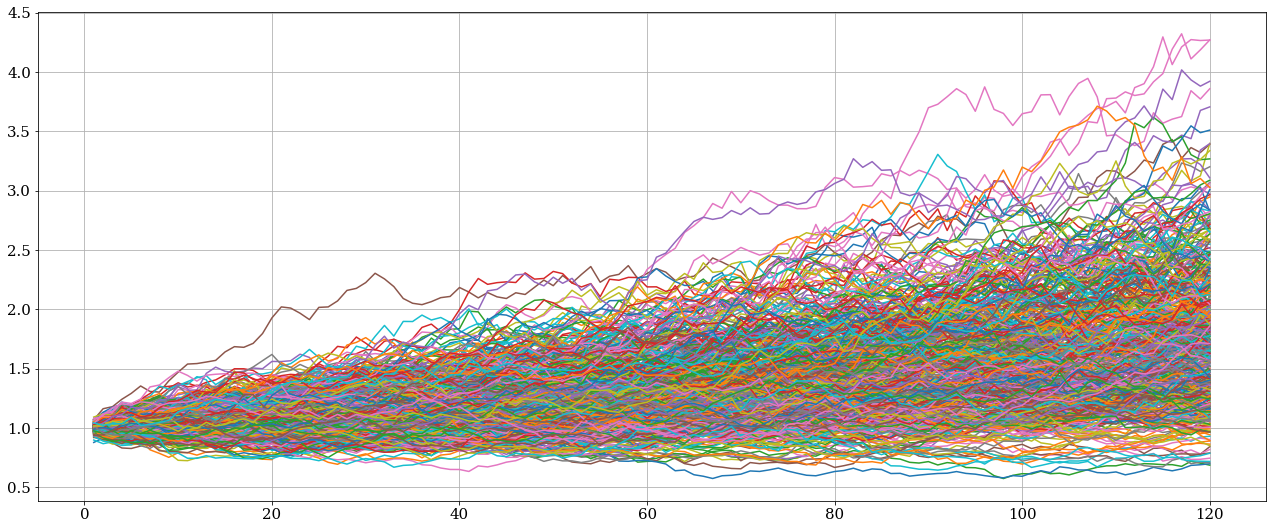

In [151]:
(1+rets_7030b).cumprod().plot(legend=False, figsize = (22,9), grid = True)

In [152]:
def terminal_values(rets):
    """
    Computes the terminal values from a set of returns supplied as a T x N DataFrame
    Return a Series of length N indexed by the columns of rets
    """
    return (rets+1).prod()

def terminal_stats(rets, floor = 0.8, cap=np.inf, name="Stats"):
    """
    Produce Summary Statistics on the terminal values per invested dollar
    across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column DataFrame of Summary Stats indexed by the stat name 
    """
    terminal_wealth = terminal_values(rets)
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = reach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std" : terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short":e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats

In [153]:
pd.concat([terminal_stats(rets_bonds, name="FI"), 
           terminal_stats(rets_eq, name="Eq"),
           terminal_stats(rets_7030b, name="70/30")],
           axis=1).round(3)

FI     Eq  70/30
mean       1.379  1.997  1.800
std        0.116  0.949  0.590
p_breach     NaN  0.038  0.014
e_short      NaN  0.154  0.065
p_reach      NaN    NaN    NaN
e_surplus    NaN    NaN    NaN

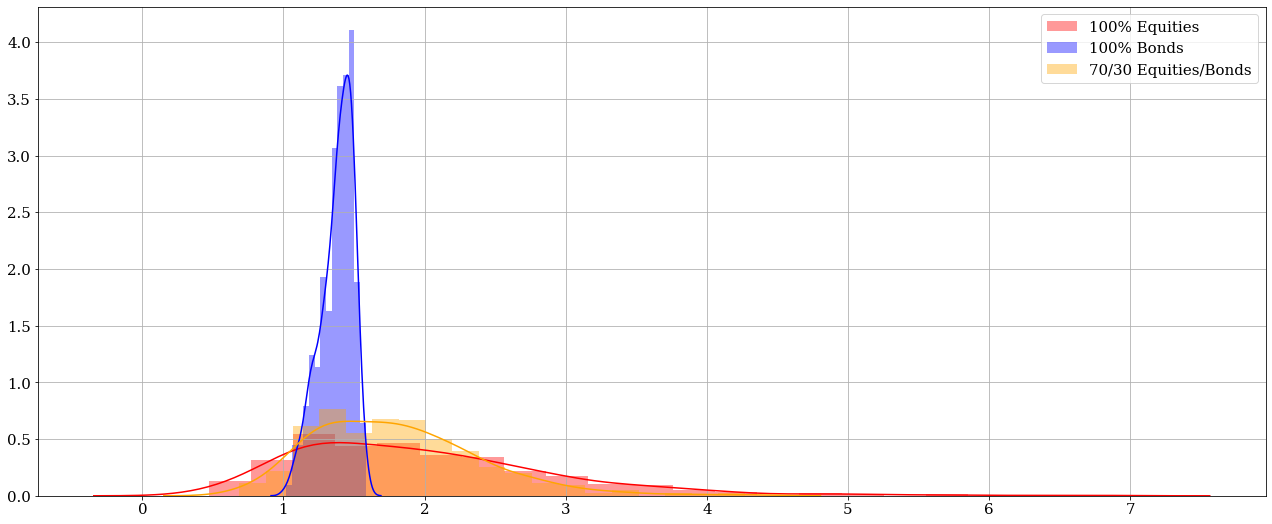

In [154]:
plt.figure(figsize=(22, 9))
sns.distplot(terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend()
plt.grid()

We can see that with the Equiy portfolio and even with the 70/30 portfolio, there is a large mass of outcomes ending below 0.8, wich was our floor. We want our Equities/Bonds allocation to get rid of that part.

## Risk Budgeting through Glide Path Allocation

A potential improvement over naive fixed mix is to risk budget by making a simplistic assumption that risk = time.

In other words, if you have more time, increase the risk budget. If you have less time, derisk. This is the thinking behind a Target Date Fund.

Let's write an allocator that defines the weights as a glidepath sthat starts at a starting weight and then gradually decreases the weights to equities over time to an ending weight. For example, you can start at 80% stocks at the start of the 10 year period and then gradually move to 20% stocks by the end of the 10 year period.

In [155]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0.0):
    """
    Allocates weights to r1 starting at start_glide and ends at end_glide
    by gradually moving from start_glide to end_glide over time
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [156]:
rets_g8020 = bt_mix(rets_eq, rets_bonds, allocator=glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([terminal_stats(rets_bonds, name="FI"), 
           terminal_stats(rets_eq, name="Eq"),
           terminal_stats(rets_7030b, name="70/30"),
           terminal_stats(rets_g8020, name="Glide 80 to 20")],
           axis=1).round(3)

FI     Eq  70/30  Glide 80 to 20
mean       1.379  1.997  1.800           1.667
std        0.116  0.949  0.590           0.427
p_breach     NaN  0.038  0.014           0.002
e_short      NaN  0.154  0.065           0.026
p_reach      NaN    NaN    NaN             NaN
e_surplus    NaN    NaN    NaN             NaN

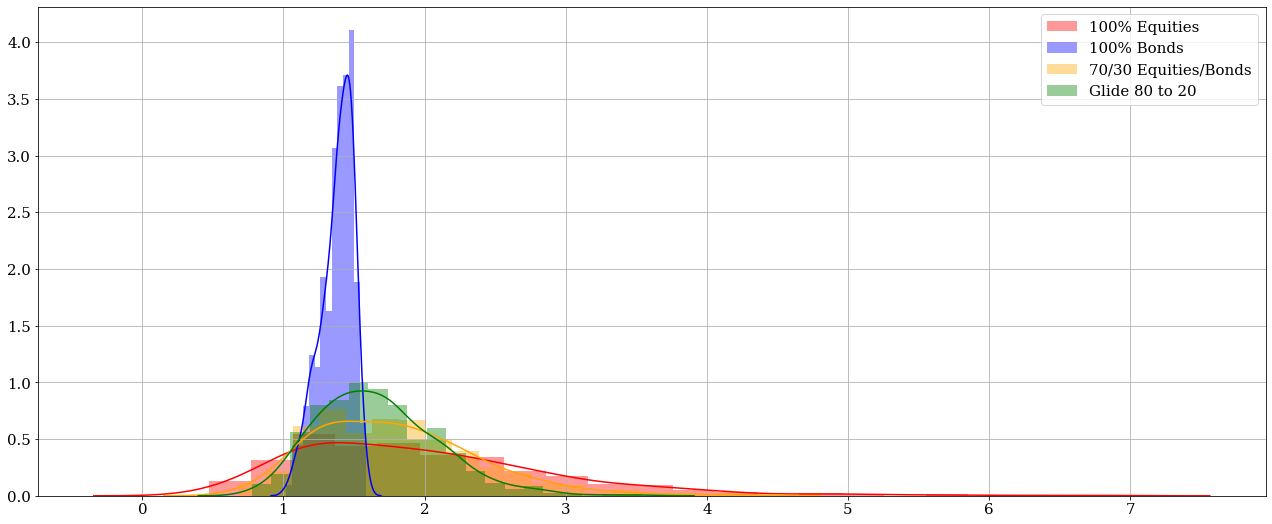

In [157]:
plt.figure(figsize=(22, 9))
sns.distplot(terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
sns.distplot(terminal_values(rets_g8020), color="green", label="Glide 80 to 20")
plt.legend()
plt.grid()

Still does not solve the problem. 

### Conclusion

Static or Naive risk budgeting involves allocating between the PSP and GHP using either a simple fixed mix or a blind glidepath. These can reduce the downside risk but come at the cost the expected return, and cannot be used to secure a minimum acceptable level of wealth or liabilities. 
We will now examine dynamic approaches that will address the challenge of meeting a set of future liabilities.


## Dynamic Risk Budgeting between PSP and GHP

Now we will look at modern dynamic techniques that are inspired by CPPI to ensure that the account value reaches a certain target minimum floor, but also maintains exposure to the upside through a dynamic risk budget.

Let's start by building 500 scenarios for interest rates, an duration matched bond portfolio (proxied by a zero coupon bond) and a stock portfolio.

In [158]:
n_scenarios =  5000
rates, zc_prices = cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma=0.02)
price_eq = f.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = bt_mix(rets_eq, rets_zc, allocator=fixedmix_allocator, w1=0.7)
pd.concat([terminal_stats(rets_zc, name="ZC", floor=0.75), 
           terminal_stats(rets_eq, name="Eq", floor=0.75),
           terminal_stats(rets_7030b, name="70/30", floor=0.75)],
          axis=1).round(2)

ZC    Eq  70/30
mean       1.34  1.96   1.75
std        0.00  1.00   0.60
p_breach    NaN  0.04   0.01
e_short     NaN  0.14   0.08
p_reach     NaN   NaN    NaN
e_surplus   NaN   NaN    NaN

Let's write a new allocator that we'll call a Floor Allocator applies a dynamic risk budget to allocate more to the PSP when there is a cushion, similar to what we did for CPPI.

In [159]:
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC Prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ## PV of Floor assuming today's rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

In [160]:
rets_floor75 = bt_mix(rets_eq, rets_zc, allocator=floor_allocator, floor=.75,  zc_prices=zc_prices[1:])
pd.concat([terminal_stats(rets_zc, name="ZC", floor=0.75), 
           terminal_stats(rets_eq, name="Eq", floor=0.75),
           terminal_stats(rets_7030b, name="70/30", floor=0.75),
           terminal_stats(rets_floor75, name="Floor75", floor=0.75),
          ],
          axis=1).round(4)

ZC      Eq   70/30  Floor75
mean       1.3433  1.9600  1.7499   1.9382
std        0.0000  0.9967  0.6025   1.0002
p_breach      NaN  0.0402  0.0112      NaN
e_short       NaN  0.1394  0.0772      NaN
p_reach       NaN     NaN     NaN      NaN
e_surplus     NaN     NaN     NaN      NaN

We can also play around with the multiple m of the CPPI strategy.

In [162]:
rets_floor75m1 = bt_mix(rets_eq, rets_zc, allocator=floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=1)
rets_floor75m5 = bt_mix(rets_eq, rets_zc, allocator=floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=5)
rets_floor75m10 = bt_mix(rets_eq, rets_zc, allocator=floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=10)

pd.concat([terminal_stats(rets_zc, name="ZC", floor=0.75), 
           terminal_stats(rets_eq, name="Eq", floor=0.75),
           terminal_stats(rets_7030b, name="70/30", floor=0.75),
           terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75)
          ],
          axis=1).round(2)

ZC    Eq  70/30  Floor75  Floor75m1  Floor75m5  Floor75m10
mean       1.34  1.96   1.75     1.94       1.62       1.95        1.95
std        0.00  1.00   0.60     1.00       0.44       1.00        1.00
p_breach    NaN  0.04   0.01      NaN        NaN        NaN        0.03
e_short     NaN  0.14   0.08      NaN        NaN        NaN        0.00
p_reach     NaN   NaN    NaN      NaN        NaN        NaN         NaN
e_surplus   NaN   NaN    NaN      NaN        NaN        NaN         NaN

In [168]:
tv_eq = terminal_values(rets_eq)
tv_zc = terminal_values(rets_zc)
tv_7030b = terminal_values(rets_7030b)
tv_floor75 = terminal_values(rets_floor75)
tv_floor75m1 = terminal_values(rets_floor75m1)
tv_floor75m5 = terminal_values(rets_floor75m5)
tv_floor75m10 = terminal_values(rets_floor75m10)

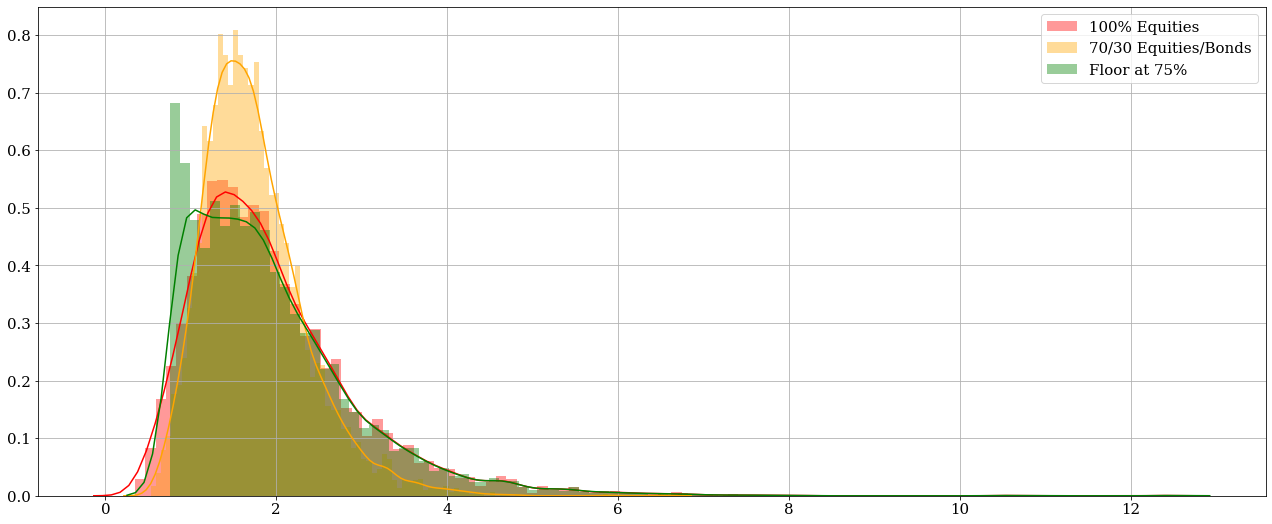

In [167]:
plt.figure(figsize=(22, 9))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.grid()
plt.legend();

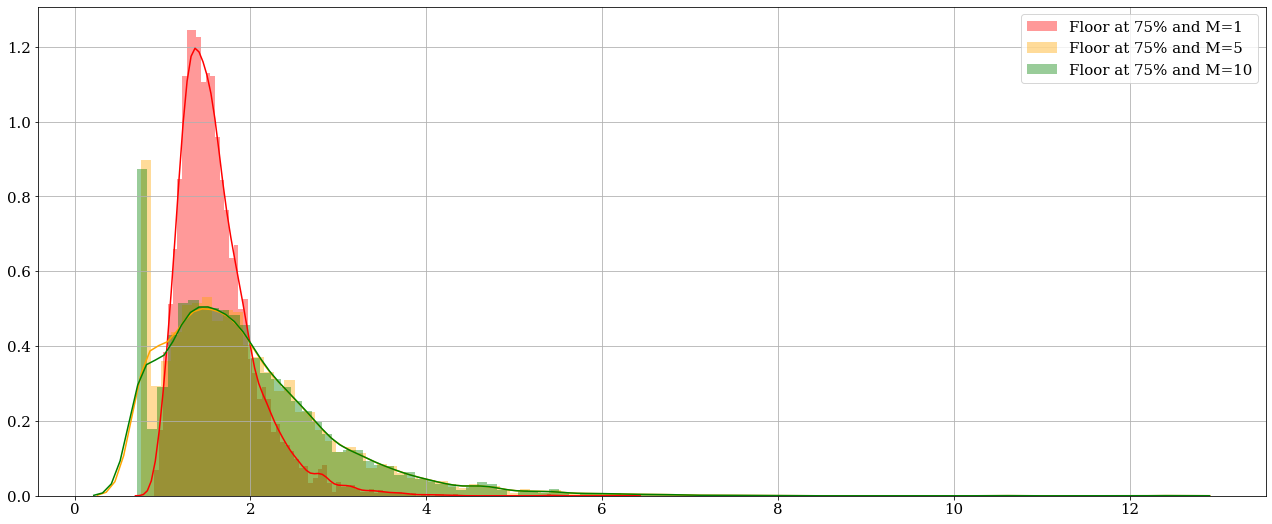

In [169]:
plt.figure(figsize=(22, 9))
sns.distplot(tv_floor75m1, color="red", label="Floor at 75% and M=1", bins=100)
sns.distplot(tv_floor75m5, color="orange", label="Floor at 75% and M=5", bins=100)
sns.distplot(tv_floor75m10, color="green", label="Floor at 75% and M=10", bins=100)
plt.grid()
plt.legend();

## Dynamic Risk Budgeting with Drawdown instead of a fixed floor

The tricky part here is that we cannot used bonds, but instead a very short duration instrument that does not decrease in price. We will use a cash account instead.

In [170]:
def drawdown_allocator(psp_r, ghp_r, maxdd, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    ### For MaxDD
    peak_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        ### For MaxDD
        floor_value = (1-maxdd)*peak_value ### Floor is based on Prev Peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        ### For MaxDD
        peak_value = np.maximum(peak_value, account_value) ### For MaxDD
        w_history.iloc[step] = psp_w
    return w_history

In [171]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = bt_mix(rets_eq, rets_cash, allocator=drawdown_allocator, maxdd=.25)
tv_maxdd25 = terminal_values(rets_maxdd25)
pd.concat([terminal_stats(rets_zc, name="ZC", floor=0.75), 
           terminal_stats(rets_eq, name="Eq", floor=0.75),
           terminal_stats(rets_7030b, name="70/30", floor=0.75),
           terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75),
           terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)           
          ],
          axis=1).round(2)

ZC    Eq  70/30  Floor75  Floor75m1  Floor75m5  Floor75m10  \
mean       1.34  1.96   1.75     1.94       1.62       1.95        1.95   
std        0.00  1.00   0.60     1.00       0.44       1.00        1.00   
p_breach    NaN  0.04   0.01      NaN        NaN        NaN        0.03   
e_short     NaN  0.14   0.08      NaN        NaN        NaN        0.00   
p_reach     NaN   NaN    NaN      NaN        NaN        NaN         NaN   
e_surplus   NaN   NaN    NaN      NaN        NaN        NaN         NaN   

           MaxDD25  
mean          1.62  
std           0.55  
p_breach       NaN  
e_short        NaN  
p_reach        NaN  
e_surplus      NaN

In [174]:
f.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23924318451464205

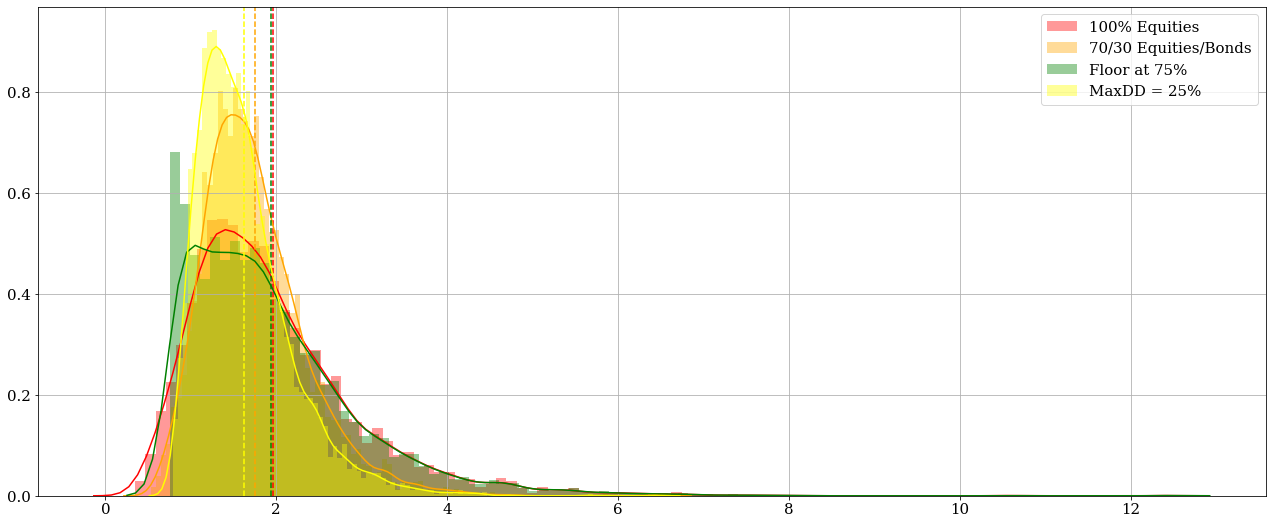

In [176]:
plt.figure(figsize=(22,9))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.grid()
plt.legend();

A large part of how these strategies operate is to shift or move the shape of the distribution towards something that is more acceptable to the investor.

## Backtesting Dynamic Strategies with Historical Data

Try and work with real historic data such as a the Industry Portfolios or the Total Market Index we constructed and run back tests with different parameter values. For instance:

In [180]:
rets_tmi =  f.get_total_market_index_returns()["1990":]
dd_tmi = f.drawdown(rets_tmi)

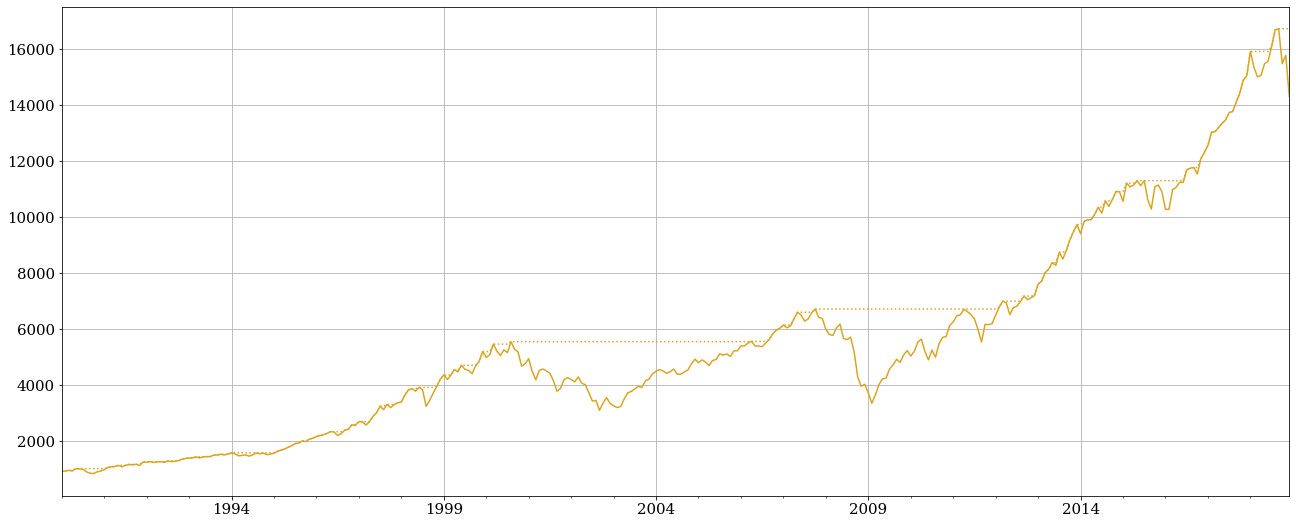

In [187]:
ax = dd_tmi["Wealth"].plot(figsize=(22,9), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod", grid = True)

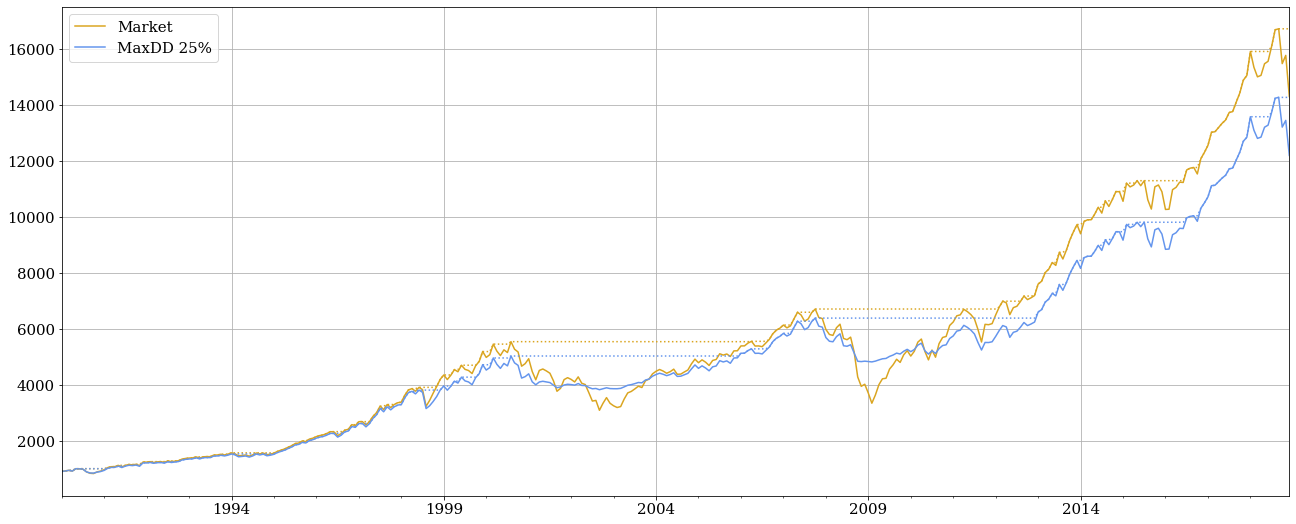

In [194]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=drawdown_allocator, maxdd=.25, m=5)
dd_25 = f.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(22,9), ls="-", color="goldenrod", label="Market", legend=True)
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":", grid = True)

In [13]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

Annualized Return  Annualized Vol  Skewness  Kurtosis  \
Market           0.096058        0.145419 -0.668827  4.247282   
MaxDD            0.090062        0.112755 -0.630463  5.015334   

        Cornish-Fisher VaR (5%)  Historic CVaR (5%)  Sharpe Ratio  \
Market                 0.066949            0.094633      0.441951   
MaxDD                  0.049978            0.071074      0.518327   

        Max Drawdown  
Market     -0.499943  
MaxDD      -0.244212